In [148]:
import quimb.tensor as qtn
import quimb as qu
import torch
Lx = 4
Ly = 2
D = 4

random_peps = qtn.PEPS.rand(Lx, Ly, D, phys_dim=2, seed=42)
random_peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

ham = qtn.ham_2d_heis(Lx, Ly, j=1.0, cyclic=False)
ham.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

random_peps.compute_local_expectation(ham.terms, normalized=True, max_bond=64)

tensor(0.1078, dtype=torch.float64)

In [149]:
# ED
# E = qu.groundenergy(qu.ham_heis_2D(Lx, Ly, j=1.0, cyclic=False))
E = -9.189207065192974 # 4x4
# E =  -4.293066456657067 # 4x2

In [150]:
su = qtn.SimpleUpdateGen(
    random_peps,
    ham,
    D=D,
    second_order_reflect=True,
    compute_energy_every=25,
    compute_energy_fn = lambda su: su.get_state().compute_local_expectation(ham.terms, normalized=True, max_bond=64),
    plot_every=10,
)

In [151]:
# su.evolve(200, tau=0.1)
# su.evolve(200, tau=0.05)

In [152]:
# su.evolve(200, tau=0.01)

In [153]:
import pickle
# su.assemble_plot_data()
# with open(f"./2D/circuitTNF_heis2D_Lx{Lx}_Ly{Ly}_D{D}_plot.pkl", "wb") as f:
#     pickle.dump(su.assemble_plot_data(), f)
# with open(f"./2D/circuitTNF_heis2D_Lx{Lx}_Ly{Ly}_D{D}_su_state.pkl", "wb") as f:
#     params, skeleton = qtn.pack(su.get_state())
#     pickle.dump((params, skeleton), f)
# Lx = 4
# Ly = 2
# D = 2
params, skeleton = pickle.load(open(f"./2D/circuitTNF_heis2D_Lx{Lx}_Ly{Ly}_D{D}_su_state.pkl", "rb"))
peps = qtn.unpack(params, skeleton)

In [154]:
ordering = ham.get_auto_ordering()

In [451]:
import quimb.tensor as qtn
from funcs import enumerate_bitstrings
from models import circuit_TNF_2d
from vmc_torch.hamiltonian_torch import spin_Heisenberg_square_lattice_torch



H = spin_Heisenberg_square_lattice_torch(Lx, Ly, J=1.0, pbc=False, total_sz=0)
ham_quimb = qtn.ham_2d_heis(Lx, Ly, j=1.0, cyclic=False)
ham_quimb.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))
graph = H.graph
hilbert = H.hilbert
dtype = torch.float64

exp_all_states = list(enumerate_bitstrings(Lx*Ly))  # noqa: F405
projected_states = torch.tensor(hilbert.all_states())
projected_states_tuple = [tuple(state.tolist()) for state in projected_states]

tau = 0.1
chi = 64
depth = 1
test_config = projected_states[1]
site_maps = dict((peps.sites[i], torch.tensor([1,0] if config == 0 else torch.tensor([0,1]))) for i, config in enumerate(test_config))
config_product_state = qtn.PEPS.product_state(site_maps)
config_product_state.apply_to_arrays(lambda x: x.type(torch.float64))
# Manual update
config_product_state_copy = config_product_state.copy()
gauges = {}
for _ in range(depth):
    for where in ordering[::-1]:
        G = ham.get_gate_expm(where, -1 * tau)
        # config_product_state_copy.gate_(
        #     G,
        #     where,
        #     contract='reduce-split'
        # )
        config_product_state_copy.gate_simple_(
            G,
            where,
            max_bond=chi,
            gauges=gauges,
            cutoff=0.0,
            renorm=False,
        )
config_product_state_copy.gauge_simple_insert(gauges)
print((config_product_state_copy | peps).contract())

# #Using SimpleUpdateGen

# product_su = qtn.SimpleUpdateGen(
#     config_product_state,
#     ham,
#     D=chi,
#     second_order_reflect=False,
#     compute_energy_every=None,
#     compute_energy_final=False,
# )
# product_su.ordering = ordering[::-1]
# product_su.evolve(depth, tau=tau)
# evolved_product_state = product_su.get_state()
# overlap = (evolved_product_state & peps).contract()
# print(overlap)  # should be the same as above

tensor(-0.0211, dtype=torch.float64)


/tmp/ipykernel_29032/3391494377.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  site_maps = dict((peps.sites[i], torch.tensor([1,0] if config == 0 else torch.tensor([0,1]))) for i, config in enumerate(test_config))


In [452]:
from models import PEPS_TNF
def form_gated_tns_tnf(
    tns,
    ham,
    depth,
    tau=0.5,
    nn_where_list=None,
    d_tag_id="ROUND_{}",
    x_tag_id="X{}",
    y_tag_id="Y{}",
    z_tag_id="ROUND_{}",
    site_tag_id_2d="I{},{}",
    site_tag_id_3d="I{},{},{}",
):
    tns1 = tns.copy()

    if not isinstance(nn_where_list, list) and not isinstance(nn_where_list, tuple):
        Warning(
            "nn_where_list is not a list of tuples, using all nearest neighbor terms in the Hamiltonian"
        )
        nn_where_list = [(i, i + 1) for i in range(tns.L - 1)]

    # Change tags for the initial tns
    for ts in tns1.tensors:
        ts.modify(tags=["ROUND_0"] + list(ts.tags))

    # Apply the gates and add corresponding tags
    for i in range(depth):
        for where in nn_where_list:
            gate = ham.get_gate_expm(where, -1 * tau)
            site_inds = [tns1.site_ind_id.format(*site) for site in where]
            extra_tags = ["ROUND_{}".format(i + 1)]
            ltag = tns1.site_tag_id.format(*where[0])
            rtag = tns1.site_tag_id.format(*where[1])
            tns1 = tns1.gate_inds(
                gate,
                inds=site_inds,
                contract="split-gate",
                tags=extra_tags,
                ltags=ltag,
                rtags=rtag,
            )

    # Contract the gates in each round to a MPO
    for i in range(1, depth + 1):
        for site in tns1.sites:
            tns1.contract_tags_(
                [tns1.site_tag_id.format(*site), f"ROUND_{i}"],
                inplace=True,
                which="all",
            )
    import itertools
    # Add site tags
    for d in range(0, depth + 1):
        for x, y in itertools.product(range(tns1.Lx), range(tns1.Ly)):
            # print(x,y)
            ts = tns1[[site_tag_id_2d.format(x, y), d_tag_id.format(d)]]
            ts.add_tag(x_tag_id.format(x))
            ts.add_tag(y_tag_id.format(y))
            ts.add_tag(z_tag_id.format(d))
            ts.add_tag(site_tag_id_3d.format(x, y, d))
    
    # return tns1

    circuit_tnf = PEPS_TNF.from_TN(tns1)
    circuit_tnf.set_depth(depth)

    return circuit_tnf

# tns = su.get_state()
tns = peps
nn_where_list = ordering
circuit_tnf = form_gated_tns_tnf(tns, ham, depth=depth, tau=0.1, nn_where_list=nn_where_list)
amp = circuit_tnf.get_amp(test_config)  # should be the same as above
amp.contract()

tensor(-0.0211, dtype=torch.float64)

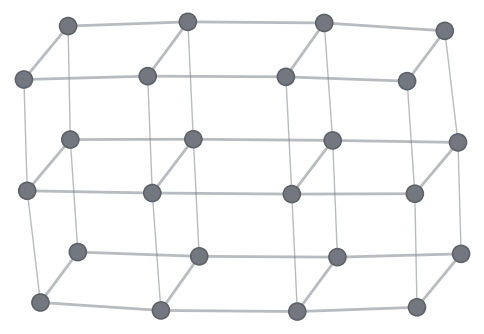

In [232]:
amp.draw()

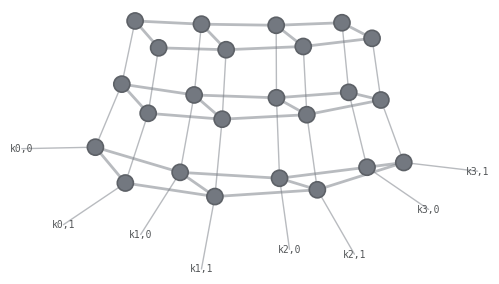

In [233]:
circuit_tnf.draw()

In [16]:
from models import circuit_TNF_2d
circuit_tnf_2d = circuit_TNF_2d(tns, ham, trotter_tau=0.1, depth=2, max_bond=8, from_which='zmax', dtype=torch.float64)
circuit_tnf_2d(test_config)

tensor([47.3850], dtype=torch.float64, grad_fn=<StackBackward0>)

In [14]:
amp_3d = circuit_tnf.get_amp(test_config)

In [13]:
amp_3d.contract_boundary_from(from_which='zmax', max_bond=8, cutoff=0.0, zrange=(0, circuit_tnf.Lz-1), xrange=(0, circuit_tnf.Lx-1), yrange=(0, circuit_tnf.Ly-1), mode='peps').contract()

tensor(47.3850, dtype=torch.float64)

In [15]:
amp_3d.contract()

tensor(47.3781, dtype=torch.float64)